In [12]:
using QuantumOptics
using NBInclude
using LinearAlgebra
using Einsum
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")
# chern 
@nbinclude("Chern_utils.ipynb")

calc_all_states_H_mb_2 (generic function with 1 method)

# Parameters

In [8]:
param_dict=Dict{}()

Dict{Any, Any}()

In [9]:
LL = [3,3]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb = 1 # number of basis
t=-1 # hopping amplitude
p=1
q=3
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

U = 0.5
param_dict["U"] = U;

In [10]:
# size of parameter space
N1 = 12
N2 = N1
dx=2*pi/N1
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

param_dict["Tx"] = Tx
param_dict["Ty"] = Ty;

In [13]:
# single ptl
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H1 = get_sp_op(basis, H_T)

E1, U1 = eigenstates(dense(H1));
E1

9-element Vector{Float64}:
 -2.7320508075688728
 -2.732050807568871
 -2.732050807568871
  0.7320508075688776
  0.7320508075688779
  0.7320508075688781
  1.9999999999999998
  1.9999999999999998
  2.0000000000000004

In [14]:
PN = 2
param_dict["PN"] = PN
states_mb = bosonstates(basis, PN)
basis_mb = get_basis_mb(param_dict)

ManyBody(onebodybasis=NLevel(N=9), states:45)

In [15]:
H1_mb = get_mb_op(basis_mb, H1);
dimH_mb = length(basis_mb)
param_dict["dimH_mb"] = dimH_mb
H_NI_mb = get_H_mb(param_dict);

In [16]:
E_NI, U_NI = eigenstates(dense(H_NI_mb));

In [17]:
E_NI[1:10]

10-element Vector{Float64}:
 -5.464101615137779
 -5.464101615137776
 -5.464101615137773
 -5.464101615137763
 -5.464101615137753
 -5.464101615137751
 -2.000000000000006
 -2.0000000000000013
 -2.0
 -1.999999999999999

In [18]:
Vint_mb = SparseOperator(basis_mb)
for m in 1:N
    Vint_mb += U/2 * number(basis_mb, m) * ( number(basis_mb, m) - identityoperator(basis_mb) ) 
end

In [19]:
m = 1
V2 = U/2 * transition(basis,m,m)⊗transition(basis,m,m)
for m in 2:N
    V2 += U/2 * transition(basis,m,m)⊗transition(basis,m,m)
end

In [31]:
V2

Operator(dim=81x81)
  basis: [NLevel(N=9) ⊗ NLevel(N=9)]sparse([1, 11, 21, 31, 41, 51, 61, 71, 81], [1, 11, 21, 31, 41, 51, 61, 71, 81], ComplexF64[0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im, 0.25 + 0.0im], 81, 81)

In [20]:
Vint2_mb = manybodyoperator(basis_mb, V2);

In [21]:
Vint2_mb

Operator(dim=45x45)
  basis: ManyBody(onebodybasis=NLevel(N=9), states:45)sparse([1, 10, 18, 25, 31, 36, 40, 43, 45], [1, 10, 18, 25, 31, 36, 40, 43, 45], ComplexF64[0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im, 0.5 + 0.0im], 45, 45)

In [22]:
isapprox( Vint_mb, Vint2_mb )

true

In [23]:
H_mb = H_NI_mb + Vint2_mb;
E_mb = eigenenergies(dense(H_mb))
E_mb[1:10]
# to be compared with projection results

10-element Vector{Float64}:
 -5.425763381179247
 -5.425763381179246
 -5.425763381179245
 -5.346240396489925
 -5.346240396489923
 -5.346240396489922
 -1.9292774894793532
 -1.9292774894793514
 -1.9292774894793503
 -1.9188553622105422

In [15]:
EEA=zeros(N1, N2, dimH_mb)
UUA=zeros(Complex{Float64}, N1, N2, dimH_mb, dimH_mb)
for it1 in 1:N1
    for it2 in 1:N2
        param_dict["θθ"]=[ Tx[it1], Ty[it2] ]
        H_NI_mb = get_H_mb(param_dict);        
        H_mb = H_NI_mb + Vint2_mb;
        #4x2
        H_mb = (H_mb'+H_mb)/2
        EEA[it1,it2,:], UUA[it1,it2,:,:] = eigen(dense(H_mb).data)
    end
end

In [16]:
bands = [[1,3],[4,6],[7,9]]

3-element Vector{Vector{Int64}}:
 [1, 3]
 [4, 6]
 [7, 9]

In [17]:
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

3-element Vector{Any}:
                2.0 - 9.7595593039401e-17im
                2.0 - 1.3754880916132389e-17im
 1.0000000000000002 + 1.145344042663902e-16im

In [42]:
# projection

substates = 1:9

basis_tilde = SubspaceBasis(basis, U1[substates])
basis_tilde2 = basis_tilde⊗basis_tilde
states_mb_tilde = bosonstates(basis_tilde, PN)
basis_mb_tilde  = ManyBodyBasis(basis_tilde, states_mb_tilde)

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:9), states:45)

In [43]:
P1 = projector(basis, basis_tilde)
P1_dag = dagger(P1)
P1M = P1.data
P1_dagM = P1_dag.data
P2M = (P1⊗P1).data
P2_dagM = (P1_dag⊗P1_dag).data;
H1M = H1.data;
V2M = V2.data;

In [44]:
@einsum H1_tildeM[i,j] := P1_dagM[i,k] * H1M[k,l] * P1M[l,j];
@einsum V2_tildeM[i2,j2] :=  P2_dagM[i2,k2] * V2M[k2,l2] * P2M[l2,j2];

In [45]:
H1_tilde = Operator(basis_tilde, H1_tildeM);

V2_tilde = Operator(basis_tilde2, V2_tildeM);

H_NI_tilde_mb = manybodyoperator(basis_mb_tilde, H1_tilde);

Vint_tilde_mb = manybodyoperator(basis_mb_tilde, V2_tilde);

H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;

H_tilde_mb = (H_tilde_mb + H_tilde_mb')/2;

In [46]:
E_tilde_mb = eigenenergies(dense(H_tilde_mb))
E_tilde_mb[1:6]
# to be compared with exact results above

6-element Vector{Float64}:
 -5.425763381179245
 -5.4257633811792445
 -5.425763381179243
 -5.346240396489927
 -5.346240396489922
 -5.346240396489919

In [47]:
println(E_mb[1:6])
println(E_tilde_mb[1:6])

[-5.425763381179247, -5.425763381179246, -5.425763381179245, -5.346240396489925, -5.346240396489923, -5.346240396489922]
[-5.425763381179245, -5.4257633811792445, -5.425763381179243, -5.346240396489927, -5.346240396489922, -5.346240396489919]


In [48]:
E_mb

45-element Vector{Float64}:
 -5.425763381179247
 -5.425763381179246
 -5.425763381179245
 -5.346240396489925
 -5.346240396489923
 -5.346240396489922
 -1.9292774894793532
 -1.9292774894793514
 -1.9292774894793503
 -1.9188553622105422
  ⋮
  2.9131403458556164
  2.9131403458556164
  2.9131403458556178
  4.092606795478502
  4.092606795478503
  4.092606795478506
  4.0997289678068976
  4.099728967806898
  4.099728967806898

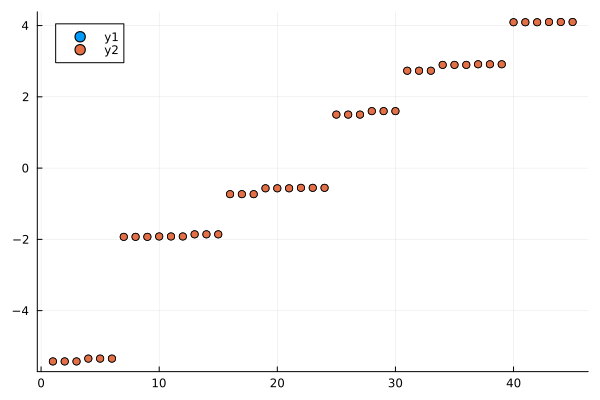

In [49]:
scatter(E_mb)
scatter!(E_tilde_mb)

In [337]:
basis_mb_tilde

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:6), states:21)

In [338]:
dimH_mb = length(basis_mb_tilde)
param_dict["dimH_mb"] = dimH_mb

21

In [339]:
EEA=zeros(N1, N2, dimH_mb)
UUA=zeros(Complex{Float64}, N1, N2, dimH_mb, dimH_mb)
for it1 in 1:N1
    for it2 in 1:N2
        param_dict["θθ"]=[ Tx[it1], Ty[it2] ]
        println(it1, ", ", it2, ": ",param_dict["θθ"])
        
        H_T = get_Hofstadter_hamiltonian(param_dict)
        H1 = get_sp_op(basis, H_T)
        E1, U1 = eigenstates(dense(H1));
        basis_tilde = SubspaceBasis(basis, U1[substates])
        
        P1 = projector(basis, basis_tilde)
        P1_dag = dagger(P1)
        P1M = P1.data
        P1_dagM = P1_dag.data
        P2M = (P1⊗P1).data
        P2_dagM = (P1_dag⊗P1_dag).data;
        H1M = H1.data;
        V2M = V2.data;
        
        @einsum H1_tildeM[i,j] := P1_dagM[i,k] * H1M[k,l] * P1M[l,j];
        @einsum V2_tildeM[i2,j2] :=  P2_dagM[i2,k2] * V2M[k2,l2] * P2M[l2,j2];
        
        basis_tilde2 = basis_tilde⊗basis_tilde
        H1_tilde = Operator(basis_tilde, H1_tildeM);
        V2_tilde = Operator(basis_tilde2, V2_tildeM);
        basis_mb_tilde  = ManyBodyBasis(basis_tilde, states_mb)
        H_NI_tilde_mb = manybodyoperator(basis_mb_tilde, H1_tilde);
        Vint_tilde_mb = manybodyoperator(basis_mb_tilde, V2_tilde);
        H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;
        
        H_mb = (H_tilde_mb'+H_tilde_mb)/2
        EEA[it1,it2,:], UUA[it1,it2,:,:] = eigen(dense(H_mb).data)
    end
end

1, 1: [0.0, 0.0]
1, 2: [0.0, 0.5235987755982988]
1, 3: [0.0, 1.0471975511965976]
1, 4: [0.0, 1.5707963267948966]
1, 5: [0.0, 2.0943951023931953]
1, 6: [0.0, 2.617993877991494]
1, 7: [0.0, 3.141592653589793]
1, 8: [0.0, 3.665191429188092]
1, 9: [0.0, 4.1887902047863905]
1, 10: [0.0, 4.71238898038469]
1, 11: [0.0, 5.235987755982988]
1, 12: [0.0, 5.759586531581287]
2, 1: [0.5235987755982988, 0.0]
2, 2: [0.5235987755982988, 0.5235987755982988]
2, 3: [0.5235987755982988, 1.0471975511965976]
2, 4: [0.5235987755982988, 1.5707963267948966]
2, 5: [0.5235987755982988, 2.0943951023931953]
2, 6: [0.5235987755982988, 2.617993877991494]
2, 7: [0.5235987755982988, 3.141592653589793]
2, 8: [0.5235987755982988, 3.665191429188092]
2, 9: [0.5235987755982988, 4.1887902047863905]
2, 10: [0.5235987755982988, 4.71238898038469]
2, 11: [0.5235987755982988, 5.235987755982988]
2, 12: [0.5235987755982988, 5.759586531581287]
3, 1: [1.0471975511965976, 0.0]
3, 2: [1.0471975511965976, 0.5235987755982988]
3, 3: [1.04

In [330]:
bands = [[1,3],[4,6]]

2-element Vector{Vector{Int64}}:
 [1, 3]
 [4, 6]

In [331]:
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

2-element Vector{Any}:
 -1.3605706137371712e-15 + 9.307138687324414e-17im
  -2.385416011097638e-16 - 4.433413329124307e-16im